In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import gaussian_kde as kde

from utils.utility_functions import makeColors

In [2]:
# map matplotlib color codes to the default seaborn palette
sns.set_color_codes()
_ = plt.plot([0, 1], color='r')
sns.set_color_codes()
_ = plt.plot([0, 2], color='b')
sns.set_color_codes()
_ = plt.plot([0, 3], color='g')
sns.set_color_codes()
_ = plt.plot([0, 4], color='m')
sns.set_color_codes()
_ = plt.plot([0, 5], color='y')
plt.close('all')

In [3]:
# channels to view
ch1 = 'Ecad_488_nucleiRingMask'
ch1_bias = 0.41

ch2 = 'PCNA_488_nucleiRingMask'
ch2_bias = 0.55

# map channel names to numbers
channel_dict = {'Ecad': 0, 'PCNA': 1}

# cell subset
num_cells = 500000

In [4]:
# I/O
out = os.path.join(os.getcwd(), 'output/gating_example')
if not os.path.exists(out):
    os.makedirs(out)

data = pd.read_parquet(os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet'))

df = data.loc[0:(num_cells - 1), [ch1, ch2]]
df = np.asarray(df)

ch1 = ch1.split('_')[0]
ch2 = ch2.split('_')[0]

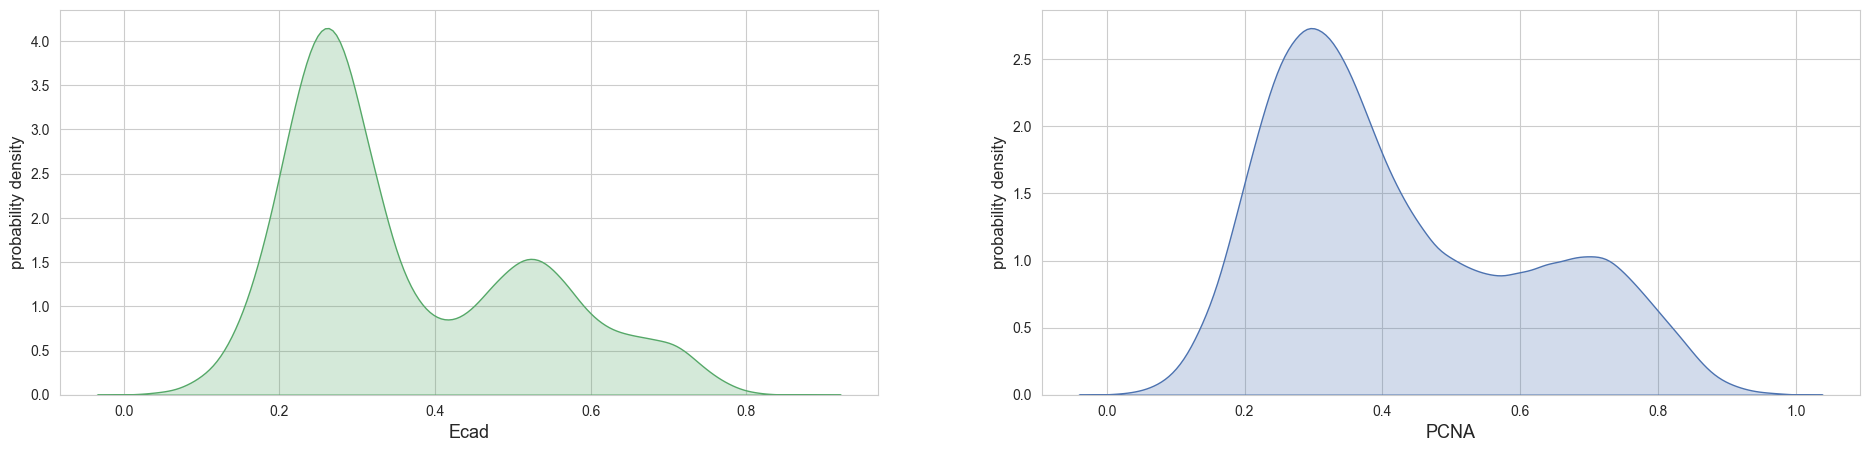

In [5]:
# plot kernel density histograms
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20, 5))

gs = gridspec.GridSpec(1, 2)
gs.update(left=0.05, right=0.95, wspace=0.2)

ch1_pre = plt.subplot(gs[0, 0])
sns.kdeplot(df[:, channel_dict[ch1]], color='g', fill=True, ax=ch1_pre)
ch1_pre.set_xlabel(ch1, fontsize=13)
ch1_pre.set_ylabel('probability density', fontsize=12)

ch2_pre = plt.subplot(gs[0, 1])
sns.kdeplot(df[:, channel_dict[ch2]], color='b', fill=True, ax=ch2_pre)
ch2_pre.set_xlabel(ch2, fontsize=13)
ch2_pre.set_ylabel('probability density', fontsize=12)

plt.savefig(os.path.join(out, f'bias_curation_plots_{ch1}_{ch2}.pdf'))
plt.show()
plt.close('all')

In [6]:
# get pre-bias density object
pre_dens = df[:, [channel_dict[ch1], channel_dict[ch2]]].T
densObj_pre = kde(pre_dens)
colors_pre = makeColors(densObj_pre.evaluate(pre_dens))

# get post-bias density object
post_dens = np.array(
    [list(df[:, channel_dict[ch1]] - ch1_bias),
     list(df[:, channel_dict[ch2]] - ch2_bias)])
densObj_post = kde(post_dens)
colors_post = makeColors(densObj_post.evaluate(post_dens))

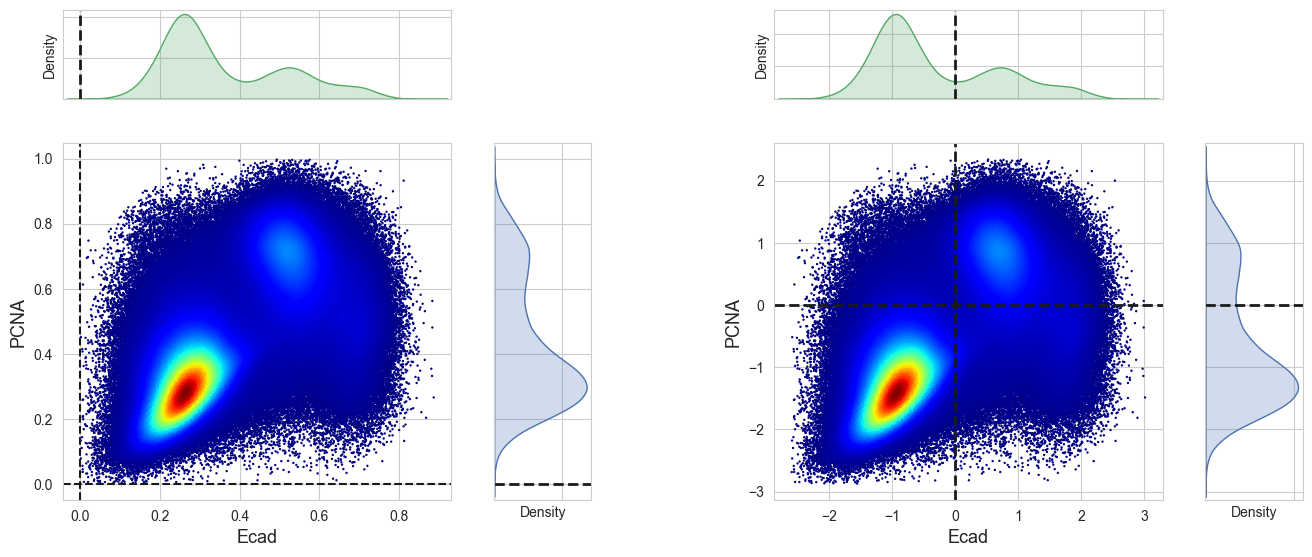

In [7]:
# joint plots with marginal distributions of pre and post-biased data normalized to std
sns.set_style('whitegrid')
fig = plt.figure(figsize=(16, 7))

gs = gridspec.GridSpec(
    2, 5, height_ratios=[0.25, 1],
    width_ratios=[1, 0.25, 0.25, 1, 0.25])
gs.update(bottom=0.18)

# PRE bias subtraction
ax_joint_pre = plt.subplot(gs[1, 0])
ax_joint_pre.scatter(df[:, channel_dict[ch1]], df[:, channel_dict[ch2]], s=0.5, c=colors_pre)
ax_joint_pre.set_xlabel(ch1, fontsize=13)
ax_joint_pre.set_ylabel(ch2, fontsize=13)
ax_joint_pre.axvline(x=0.0, color='k', linestyle='--')
ax_joint_pre.axhline(y=0.0, color='k', linestyle='--')
xmin, xmax = ax_joint_pre.get_xlim()
ymin, ymax = ax_joint_pre.get_ylim()

ax_xmarg_pre = plt.subplot(gs[0, 0])
sns.kdeplot(df[:, channel_dict[ch1]], color='g', fill=True, ax=ax_xmarg_pre)
plt.setp(ax_xmarg_pre.get_xticklabels(), visible=False)
plt.setp(ax_xmarg_pre.get_yticklabels(), visible=False)
ax_xmarg_pre.axvline(x=0.0, color='k', linestyle='--', lw=2)
ax_xmarg_pre.set_xlim(xmin, xmax)

ax_ymarg_pre = plt.subplot(gs[1, 1])
sns.kdeplot(y=df[:, channel_dict[ch2]], color='b', fill=True, ax=ax_ymarg_pre)
plt.setp(ax_ymarg_pre.get_xticklabels(), visible=False)
plt.setp(ax_ymarg_pre.get_yticklabels(), visible=False)
ax_ymarg_pre.axhline(y=0.0, color='k', linestyle='--', lw=2)
ax_ymarg_pre.set_ylim(ymin, ymax)

# POST bias subtraction
ax_joint_post = plt.subplot(gs[1, 3])
ax_joint_post.scatter(
    ((df[:, channel_dict[ch1]] - ch1_bias) /
     np.std(df[:, channel_dict[ch1]])),
    ((df[:, channel_dict[ch2]] - ch2_bias) /
     np.std(df[:, channel_dict[ch2]])), s=0.5, c=colors_post)
ax_joint_post.set_xlabel(ch1, fontsize=13)
ax_joint_post.set_ylabel(ch2, fontsize=13)
ax_joint_post.axvline(x=0.0, color='k', linestyle='--', lw=2)
ax_joint_post.axhline(y=0.0, color='k', linestyle='--', lw=2)
xmin, xmax = ax_joint_post.get_xlim()
ymin, ymax = ax_joint_post.get_ylim()

ax_xmarg_post = plt.subplot(gs[0, 3])
sns.kdeplot(
    ((df[:, channel_dict[ch1]] - ch1_bias) /
     np.std(df[:, channel_dict[ch1]])),
    color='g', fill=True, ax=ax_xmarg_post)
plt.setp(ax_xmarg_post.get_xticklabels(), visible=False)
plt.setp(ax_xmarg_post.get_yticklabels(), visible=False)
ax_xmarg_post.axvline(x=0.0, color='k', linestyle='--', lw=2)
ax_xmarg_post.set_xlim(xmin, xmax)

ax_ymarg_post = plt.subplot(gs[1, 4])
sns.kdeplot(
    y=((df[:, channel_dict[ch2]] - ch2_bias) /
       np.std(df[:, channel_dict[ch2]])),
    color='b', fill=True, ax=ax_ymarg_post)
plt.setp(ax_ymarg_post.get_xticklabels(), visible=False)
plt.setp(ax_ymarg_post.get_yticklabels(), visible=False)
ax_ymarg_post.axhline(y=0.0, color='k', linestyle='--', lw=2)
ax_ymarg_post.set_ylim(ymin, ymax)

plt.savefig(
    os.path.join(out, f'pre_post_bias_plots_{ch1}_{ch2}.png'), dpi=800, bbox_inches='tight'
)
plt.show()
plt.close('all')